In [113]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [114]:
# import sys

# sys.path.insert(1, '/kaggle/input/mymodules')

import my_module

In [115]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

all_data = pd.concat([train, test], ignore_index=True)
df = all_data.copy(deep=True)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


<a id='1'> </a>

# 1. EDA


Let's delete all columns with a lot of nan values


In [116]:
df = my_module.delete_nan_column(df, 0.25)

In [117]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

# 1.1 Numeric features


In [118]:
px.imshow(df.corr(), color_continuous_scale=cm, width=1000, height=1000)

First of all, I'm going to work with the features which are highly correlated with SalePrice.

Some of these features are correlated with each other, so I'm going to keep one of them and drop the other. For instance:

- YearBuilt and GarageYrBlt
- GarageArea and GarageCars


In [119]:
numeric_features = df.select_dtypes(include=["float64", "int64"]).columns

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

Let's examine ditributions and try to find obvious outliers


In [120]:
# df[numeric_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Select the most correlated features


In [121]:
numeric_corr_features = my_module.get_corr_features(
    df[numeric_features].corr()["SalePrice"], 0.25
)

In [122]:
for_plotting = [
    "OverallQual",
    "YearBuilt",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "SalePrice",
]

# sns.pairplot(df[for_plotting + ["Train_test"]], diag_kind="kde", hue="Train_test")

There is a significant outlier.


In [123]:
df[df["1stFlrSF"] > 4500][numeric_corr_features]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
1298,313.00,63887,10,2008,2008,796.00,5644.00,6110.00,4692,950,...,2,1,12,3,2008.00,2.00,1418.00,214,292,160000.00
2549,128.00,39290,10,2008,2009,1224.00,4010.00,5095.00,5095,0,...,2,1,15,2,2008.00,3.00,1154.00,546,484,NaN


1298 is the one. All positive correlated features are quite high, but the price is relatively low. I'll just delete it.


In [124]:
df.drop([1298], inplace=True)

### YearBuilt/YearRemodAdd


I combined YearBuilt and YearRemodAdd in a column


In [125]:
df["YearBuilt/Remod"] = df["YearBuilt"].copy()
df.loc[df["YearBuilt"] > 1950, "YearBuilt/Remod"] = df.loc[
    df["YearBuilt"] > 1950, "YearRemodAdd"
]

In [126]:
px.histogram(df, x="YearBuilt/Remod", color="Train_test")

In [127]:
df.loc[df["YearBuilt/Remod"] < 1895, "YearBuilt/Remod"] = 1895

### GarageYrlBlt


In [128]:
px.histogram(df, x="GarageYrBlt", y="YearBuilt/Remod", color="Train_test")

In [129]:
px.scatter(df, x="GarageYrBlt", y="YearBuilt/Remod", color="Train_test")

In [130]:
df.loc[df["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

In [131]:
px.scatter(df, x="GarageYrBlt", y="SalePrice")

In [132]:
df.loc[df["GarageYrBlt"].isnull(), "GarageYrBlt"] = df["YearBuilt/Remod"]

### OverallCond


Overall Cond has low correlation, but it effects the average price.


In [133]:
px.histogram(df, x="OverallCond", y="SalePrice", histfunc="avg")

# Clipping


One of the ways to deal with outliers is clipping. We change extremely large or small values to be closer to the average values. I only work with the features which don't include many zeros.


In [134]:
df.loc[df["SalePrice"] > 480000, "SalePrice"] = 480000
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950
df.loc[df["GarageCars"] > 3, "GarageCars"] = 3
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250
df.loc[df["GrLivArea"] > 2900, "GrLivArea"] = 2900
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500
df.loc[df["FullBath"] == 0, "FullBath"] = 1
df.loc[df["FullBath"] == 4, "FullBath"] = 3
df.loc[df["HalfBath"] == 2, "HalfBath"] = 1
df.loc[df["Fireplaces"] > 2, "Fireplaces"] = 2
df.loc[df["LotFrontage"] > 150, "LotFrontage"] = 150
df.loc[df["LotArea"] > 50000, "LotArea"] = 50000
df.loc[df["TotRmsAbvGrd"] > 12, "TotRnsAbvGrd"] = 12

# 1.2 Categorical features


In [135]:
cat_features = df.select_dtypes(include=["object"]).columns
df[cat_features] = df[cat_features].fillna("NO")
cat_pred_features = []

In [136]:
quals = ["ExterQual", "BsmtQual", "KitchenQual", "GarageQual"]

figs = []

for q in quals:
    figs.append(px.histogram(df, x=q, color="Train_test", height=300, width=600))
    figs.append(
        px.histogram(df, x=q, y="SalePrice", histfunc="avg", height=300, width=600)
    )

for fig in figs:
    fig.show()

We see, that higher quality means higher average price. Let's convert categories to numbers


In [137]:
quality = dict(zip(["NO", "Po", "Fa", "TA", "Gd", "Ex"], range(6)))
df.replace({col: quality for col in quals}, inplace=True)
df[quals]
cat_pred_features.extend(quals)

<a id="2"></a>

# 2. Preprocessing


In [138]:
features = [
    "OverallCond",
    "YearBuilt/Remod",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "FullBath",
    "TotRmsAbvGrd",
    "HalfBath",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "SalePrice",
]

features = cat_pred_features + features

In [139]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 2918
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ExterQual        2918 non-null   int64  
 1   BsmtQual         2918 non-null   int64  
 2   KitchenQual      2918 non-null   int64  
 3   GarageQual       2918 non-null   int64  
 4   OverallCond      2918 non-null   int64  
 5   YearBuilt/Remod  2918 non-null   int64  
 6   LotFrontage      2432 non-null   float64
 7   LotArea          2918 non-null   int64  
 8   OverallQual      2918 non-null   int64  
 9   TotalBsmtSF      2917 non-null   float64
 10  1stFlrSF         2918 non-null   int64  
 11  GrLivArea        2918 non-null   int64  
 12  FullBath         2918 non-null   int64  
 13  TotRmsAbvGrd     2918 non-null   int64  
 14  HalfBath         2918 non-null   int64  
 15  Fireplaces       2918 non-null   int64  
 16  GarageYrBlt      2918 non-null   float64
 17  GarageCars    

Imput median values in the numeric columns


In [140]:
df_final = df[features].copy(deep=True)

In [141]:
for col in features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df_final[[col]] = imp.fit_transform(df_final[[col]])

### Transform the features


In [142]:
df_final.columns

Index(['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual', 'OverallCond',
       'YearBuilt/Remod', 'LotFrontage', 'LotArea', 'OverallQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'HalfBath', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

In [143]:
power = preprocessing.PowerTransformer(standardize=False)
for_tranform = [
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "GarageArea",
    "LotFrontage",
    "LotArea",
]
df_final[for_tranform] = power.fit_transform(df_final[for_tranform])
df_final.head()

,ExterQual,BsmtQual,KitchenQual,GarageQual,OverallCond,YearBuilt/Remod,LotFrontage,LotArea,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,HalfBath,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,4.00,4.00,4.00,3.00,5.00,2003.00,28.00,39.02,7.00,319.53,7.44,11.85,2.00,8.00,1.00,0.00,2003.00,2.00,232.04,208500.00
1,3.00,4.00,3.00,3.00,8.00,1976.00,32.76,40.52,6.00,440.67,7.91,11.14,2.00,6.00,0.00,1.00,1976.00,2.00,200.35,181500.00
2,4.00,4.00,4.00,3.00,5.00,2002.00,28.98,42.46,7.00,339.19,7.53,11.96,2.00,6.00,1.00,1.00,2001.00,2.00,253.16,223500.00
3,3.00,3.00,4.00,3.00,5.00,1915.00,26.36,40.46,7.00,288.28,7.58,11.86,1.00,7.00,0.00,1.00,1998.00,3.00,264.97,140000.00
4,4.00,4.00,4.00,3.00,5.00,2000.00,33.98,45.52,8.00,406.56,7.79,12.46,2.00,9.00,1.00,1.00,2000.00,3.00,330.61,250000.00


Scalling


In [144]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

,ExterQual,BsmtQual,KitchenQual,GarageQual,OverallCond,YearBuilt/Remod,LotFrontage,LotArea,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,HalfBath,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,1.04,0.58,0.74,0.28,-0.51,0.92,-0.15,-0.17,0.65,-0.41,-0.78,0.57,0.80,0.99,1.30,-0.94,1.00,0.32,0.40,208500.00
1,-0.68,0.58,-0.77,0.28,2.19,0.05,0.58,0.09,-0.06,0.54,0.43,-0.39,0.80,-0.29,-0.77,0.65,-0.01,0.32,-0.00,181500.00
2,1.04,0.58,0.74,0.28,-0.51,0.89,-0.00,0.43,0.65,-0.26,-0.56,0.71,0.80,-0.29,1.30,0.65,0.93,0.32,0.67,223500.00
3,-0.68,-0.53,0.74,0.28,-0.51,-1.92,-0.41,0.08,0.65,-0.66,-0.42,0.58,-1.06,0.35,-0.77,0.65,0.82,1.66,0.82,140000.00
4,1.04,0.58,0.74,0.28,-0.51,0.83,0.77,0.97,1.36,0.27,0.12,1.38,0.80,1.63,1.30,0.65,0.89,1.66,1.65,250000.00


<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [145]:
df_final.columns

Index(['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual', 'OverallCond',
       'YearBuilt/Remod', 'LotFrontage', 'LotArea', 'OverallQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'HalfBath', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

Selected features after testing


In [254]:
for_prediction = [
    "ExterQual",
    "BsmtQual",
    # 'KitchenQual',
    # 'GarageQual',
    "OverallQual",
    "LotArea",
    "OverallCond",
    "YearBuilt/Remod",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    # "GarageYrBlt",
    "GarageCars",
    "Fireplaces",
    # "FullBath",
    # 'TotRmsAbvGrd',
    # 'LotFrontage',
    "SalePrice",
]

df_features = df_final[for_prediction]

In [255]:
rng = 2
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [256]:
my_module.check_distribution(x_train, x_test).all()

True

As we predict a continues value, we can use a mean value as a baseline


In [257]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5692225017.019124
RMSLE: 0.4029462115309053
R2: -6.720193158330802e+30
______


<a id='3.2'></a>

## 3.2 Simple NN model


Final training loss: 616676800.0
Final Validation loss: 736513024.0
10/10 [==============================] - 0s 1ms/step
MSE: 622659025.9865992
RMSLE: 0.15145209512992122
R2: 0.8848069938106569
______


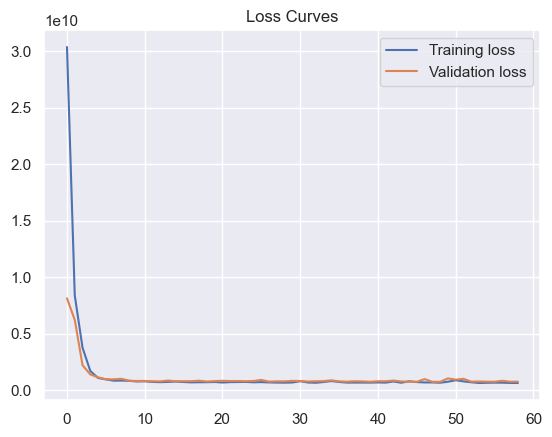

In [262]:
def create_model(learning_rate, epochs, batch_size):
    model = None

    # Define model
    model = keras.Sequential()
    model.add(
        keras.layers.Dense(
            units=x_train.shape[1],
            activation="relu",
            input_dim=x_train.shape[1],
            kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
        ),
    )
    model.add(
        keras.layers.Dense(
            units=x_train.shape[1],
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
        )
    )

    model.add(keras.layers.Dense(units=1, activation="linear"))
    # Specify the optimizer using the TF API to specify the learning rate
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    return model


learning_rate = 0.5
epochs = 100
batch_size = 50
model = create_model(learning_rate, epochs, batch_size)


earlystop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.01, patience=10, verbose=0, mode="auto"
)

callbacks_list = [earlystop]

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
    callbacks=earlystop,
)
# Plot
my_module.showRegressionResults(trainHistory)

my_module.print_evaluate_regression(y_test, model.predict(x_test))

In [259]:
import logging

logname = "model_results.log"

logging.basicConfig(
    filename=logname,
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

logger = logging.getLogger("my_logger")

logging.info("Logging set")
logging.info(model.to_json())
logging.info(for_prediction[:-1])
my_module.log_evaluate_regression(model.predict(x_test), y_test)
logging.shutdown()

10/10 [==============================] - 0s 1ms/step


In [260]:
x_sub = df_final.loc[df["SalePrice"].isna()][for_prediction[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": pred})
my_module.test_nulls(sub)
sub.to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 1ms/step
Engineered features do not contain nulls.
